In [3]:
# source code: https://www.kaggle.com/code/parthsoni1007/deepfakedetection/notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
print(tf.test.gpu_device_name())


/device:GPU:0


2023-10-04 20:22:09.232490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 20:22:09.232610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 20:22:09.232686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
!nvidia-smi


Wed Oct  4 20:22:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 77%   47C    P2    43W / 170W |    720MiB / 12288MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:


print("now for tf::")
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
# Specify GPU device if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print("Using GPU:", physical_devices[0])
else:
    print("No GPU available.")


now for tf::
TensorFlow version: 2.14.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
base_dir = './Dataset'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
validation_dir = os.path.join(base_dir, 'Validation')


In [7]:
def check_dist(dir):
    print(f"{dir.split('/')[-1]} dataset")
    if os.path.exists(dir):
        real_path = os.path.join(dir, 'Real')
        fake_path = os.path.join(dir, 'Fake')
        print(f"Real data count: {len(os.listdir(real_path))}")
        print(f"Fake data count: {len(os.listdir(fake_path))}")
    else:
        print("Directory Not Found")
    print()


In [9]:
check_dist(train_dir)
check_dist(validation_dir)
check_dist(test_dir)


Train dataset
Real data count: 70001
Fake data count: 70001

Validation dataset
Real data count: 19787
Fake data count: 19641

Test dataset
Real data count: 5413
Fake data count: 5492



In [10]:
def normalize_image(image, labels):
    image = tf.cast(image, tf.float32) / 255.0
    return image, labels


In [11]:
IMG_SIZE = (256, 256)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,           # Directory containing the training images
    label_mode='categorical',  # How labels should be encoded
    batch_size=64,       # Batch size for training data
    image_size=IMG_SIZE  # Target image size (width, height) for resizing
)


validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                      label_mode='categorical',
                                                                      batch_size=64,
                                                                      image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)


Found 140002 files belonging to 2 classes.


2023-10-04 20:27:45.054979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 20:27:45.055097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 20:27:45.055161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [12]:
train_data = train_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)
test_data = test_data.map(normalize_image)


In [13]:
# if already trained:
# Load the saved model
# model = keras.models.load_model('deepfakeModel.h5')
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11, 11), strides=(
        4, 4), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(
        5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=256, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(
        1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(
        1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2, activation='softmax')
])


In [14]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='BinaryCrossentropy',
              metrics=['accuracy'])


model_checkpoint = ModelCheckpoint(
    filepath='./model_epoch_{epoch:02d}.h5', save_best_only=True)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)


In [16]:
history = model.fit(train_data,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=int(0.7 * len(validation_data)),
                    callbacks=[model_checkpoint, early_stopping]
                    )


Epoch 1/30


2023-10-04 20:28:32.455088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-10-04 20:28:33.358754: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-10-04 20:28:33.359732: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-04 20:28:33.974067: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-10-04 20:28:33.975060: W

   3/2188 [..............................] - ETA: 2:09 - loss: 1.5273 - accuracy: 0.6146 

2023-10-04 20:28:37.411381: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2188/2188 [==============================] - 152s 66ms/step - loss: 0.3479 - accuracy: 0.8415 - val_loss: 0.2501 - val_accuracy: 0.8940
Epoch 2/30


/home/priel/anaconda3/envs/tf_venv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2188/2188 [==============================] - 143s 65ms/step - loss: 0.1536 - accuracy: 0.9399 - val_loss: 0.5582 - val_accuracy: 0.7963
Epoch 3/30
2188/2188 [==============================] - 142s 65ms/step - loss: 0.1134 - accuracy: 0.9563 - val_loss: 0.2429 - val_accuracy: 0.8928
Epoch 4/30
2188/2188 [==============================] - 143s 65ms/step - loss: 0.0925 - accuracy: 0.9644 - val_loss: 0.1778 - val_accuracy: 0.9379
Epoch 5/30
2188/2188 [==============================] - 143s 65ms/step - loss: 0.0783 - accuracy: 0.9698 - val_loss: 0.1466 - val_accuracy: 0.9508
Epoch 6/30
2188/2188 [==============================] - 143s 65ms/step - loss: 0.0669 - accuracy: 0.9742 - val_loss: 0.1779 - val_accuracy: 0.9360
Epoch 7/30
2188/2188 [==============================] - 137s 63ms/step - loss: 0.0572 - accuracy: 0.9782 - val_loss: 0.1894 - val_accuracy: 0.9432
Epoch 8/30
2188/2188 [==============================] - 136s 62ms/step - loss: 0.0473 - accuracy: 0.9813 - val_loss: 0.2187 - val

In [65]:
# model.save('deepfakeModel.keras')
history.history

AttributeError: 'numpy.ndarray' object has no attribute 'history'

In [72]:

# saving
# np.save('model_history.npy',history)

# loading
# history=np.load('model_history.npy',allow_pickle='TRUE').item()

# here the zipped version
history


{'loss': [0.34790945053100586,
  0.15355227887630463,
  0.11340195685625076,
  0.09252800792455673,
  0.0783180221915245,
  0.06692443788051605,
  0.05721592158079147,
  0.04725612327456474,
  0.04215753450989723,
  0.03899504616856575],
 'accuracy': [0.8415094017982483,
  0.9398865699768066,
  0.9563291668891907,
  0.964379072189331,
  0.9697647094726562,
  0.9741503596305847,
  0.9782074689865112,
  0.9813145399093628,
  0.9832074046134949,
  0.9852216243743896],
 'val_loss': [0.2500734329223633,
  0.5581889748573303,
  0.24285726249217987,
  0.1777568757534027,
  0.14660532772541046,
  0.17793864011764526,
  0.18938878178596497,
  0.21868981420993805,
  0.1747196465730667,
  0.16252584755420685],
 'val_accuracy': [0.89399653673172,
  0.7963312268257141,
  0.8928001523017883,
  0.9378987550735474,
  0.9508048295974731,
  0.9360498785972595,
  0.9431554675102234,
  0.9360498785972595,
  0.9475783109664917,
  0.9505510330200195]}

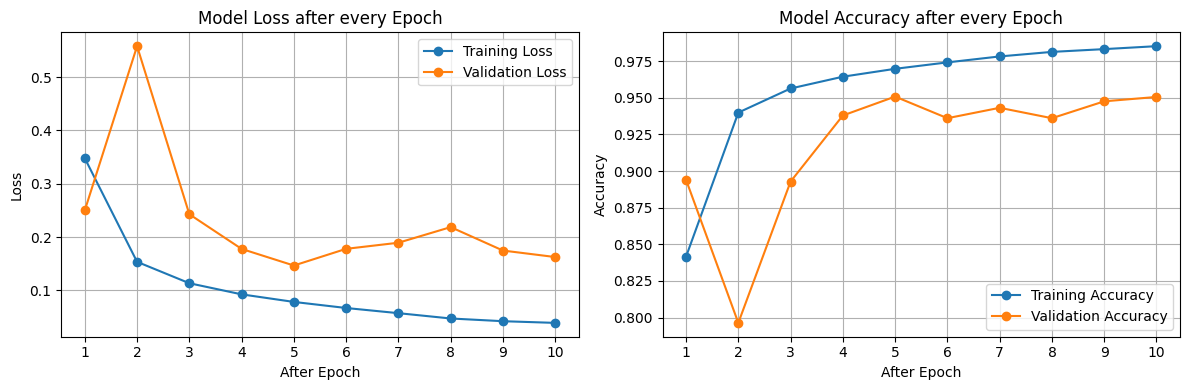

In [75]:
import matplotlib.pyplot as plt

# Assuming you have 'epochs' and 'history' defined
epochs = range(1, len(history['loss']) + 1)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation loss values
axes[0].plot(epochs, history['loss'], label='Training Loss', marker='o', linestyle='-')
axes[0].plot(epochs, history['val_loss'], label='Validation Loss', marker='o', linestyle='-')
axes[0].set_title('Model Loss after every Epoch')
axes[0].set_xlabel('After Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(epochs)  # Explicitly set x-axis ticks for the first subplot

# Plot training & validation accuracy values
axes[1].plot(epochs, history['accuracy'], label='Training Accuracy', marker='o', linestyle='-')
axes[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-')
axes[1].set_title('Model Accuracy after every Epoch')
axes[1].set_xlabel('After Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(epochs)  # Explicitly set x-axis ticks for the second subplot

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()


In [77]:
results = model.evaluate(test_data)


341/341 [==============================] - 6s 18ms/step - loss: 0.2803 - accuracy: 0.9027
test loss, test acc: [0.2803189754486084, 0.902705192565918]


In [78]:
print(f"test loss = {results[0]}, test accuracy = {results[1]}")

test loss = 0.2803189754486084, test accuracy = 0.902705192565918
